In [62]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate,BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback

def unet(height, width):
    input_shape = (height, width, 6)
    inputs = Input(input_shape)

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decoder
    up5 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(conv4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    
    up7 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    output = Conv2D(2, (1,1), activation='sigmoid')(conv7)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [63]:
class BatchLossCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_batch_losses = []
        self.val_batch_losses = []
        self.train_batch_accuracy = []  # Added
        self.val_batch_accuracy = []  # Added

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        batch_loss = logs.get('loss')
        batch_accuracy = logs.get('accuracy')  # Added
        if batch_loss is not None:
            self.train_batch_losses.append(batch_loss)
        if batch_accuracy is not None:  # Added
            self.train_batch_accuracy.append(batch_accuracy)
        # print(f'For batch {batch}, loss is {batch_loss}, accuracy is {batch_accuracy}')

    def on_test_batch_end(self, batch, logs=None):
        logs = logs or {}
        batch_loss = logs.get('loss')
        batch_accuracy = logs.get('accuracy')  # Added
        if batch_loss is not None:
            self.val_batch_losses.append(batch_loss)
        if batch_accuracy is not None:  # Added
            self.val_batch_accuracy.append(batch_accuracy)
        #print(f'For batch {batch}, loss is {batch_loss}, accuracy is {batch_accuracy}')

In [64]:

import numpy as np
import matplotlib.pyplot as plt
import os

def get_newlabel(data0):
    max_index = np.argmax(data0)
    h_index=max_index%data0.shape[1]
    interval=data0.shape[1]/3.0
    return int(h_index/interval)

filename=[]
def read_file(dir1):
    data1=[]
    data2=[]
    files= os.listdir(dir1)
    for file in files:
        if(file[:4])=='Inpt':
            filename.append(file)
            data0=np.load(dir1+file)
            data1.append(data0)
            filelbale=dir1+'label_pdf_'+file[5:]
            data0=np.load(filelbale)
            #data0=(data0-np.min(data0))/(np.max(data0)-np.min(data0))
            data2.append(data0)
            
            if(data0.shape[2]==24):
                print(filelbale,data0.shape[2])
    return filename,np.array(data1),np.array(data2)


filename,data_traing,data_traing_label=read_file('data/')
data_traing_input_tf=data_traing.transpose(0,2,3,1)
data_traing_label_tf=data_traing_label.transpose(0,2,3,1)

In [65]:
data_traing_input_tf.shape

(8000, 24, 32, 6)

In [67]:
np.save('data_traing_input_tf',data_traing_input_tf)
np.save('data_traing_label_tf',data_traing_label_tf)
np.save('filename',filename)

In [74]:
filename[300][5:-4]

'1268'

In [ ]:
#If data have been saved
data_traing_input_tf=np.load('data_traing_input_tf')
data_traing_label_tf=np.load('data_traing_label_tf')
filename=np.load('filename')

In [7]:
np.random.seed(122) #122
index_data=np.arange(0,len(data_traing_label_tf),1)
np.random.shuffle(index_data)

filename=np.array(filename)
filename=filename[index_data]
data_traing_label_tf_shuffle=data_traing_label_tf[index_data]
data_traing_input_tf_shuffle=data_traing_input_tf[index_data]

In [14]:
height=24
width=32


model = unet(height, width)
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 32, 6)]  0           []                               
                                                                                                  
 conv2d_17 (Conv2D)             (None, 24, 32, 64)   3520        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 24, 32, 64)  256         ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_18 (Conv2D)             (None, 24, 32, 64)   36928       ['batch_normalization_16[0]

 conv2d_transpose_5 (Conv2DTran  (None, 24, 32, 64)  73792       ['batch_normalization_27[0][0]'] 
 spose)                                                                                           
                                                                                                  
 concatenate_5 (Concatenate)    (None, 24, 32, 128)  0           ['batch_normalization_17[0][0]', 
                                                                  'conv2d_transpose_5[0][0]']     
                                                                                                  
 conv2d_29 (Conv2D)             (None, 24, 32, 64)   73792       ['concatenate_5[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 24, 32, 64)  256         ['conv2d_29[0][0]']              
 ormalization)                                                                                    
          

In [15]:
Adam = optimizers.Adam()
model.compile(optimizer=Adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
# 实例化自定义回调
batch_loss_callback = BatchLossCallback()



In [77]:
csv_logger = tf.keras.callbacks.CSVLogger('UNet_model/training_batch2.log')
test_interval=int(0.1*len(data_traing_input_tf))
history = model.fit(data_traing_input_tf_shuffle[:-test_interval], data_traing_label_tf_shuffle[:-test_interval],batch_size=200,verbose=1,\
                    epochs=4, validation_data=(data_traing_input_tf_shuffle[-test_interval:], data_traing_label_tf_shuffle[-test_interval:]),\
                    callbacks=[csv_logger,batch_loss_callback])

Epoch 1/4
36/36 [==============================] - 890s 24s/step - loss: 0.1220 - accuracy: 0.7894 - val_loss: 0.1474 - val_accuracy: 0.7483
Epoch 2/4
36/36 [==============================] - 1067s 30s/step - loss: 0.1214 - accuracy: 0.7900 - val_loss: 0.1484 - val_accuracy: 0.7495
Epoch 3/4
36/36 [==============================] - 1743s 48s/step - loss: 0.1204 - accuracy: 0.7907 - val_loss: 0.1445 - val_accuracy: 0.7265
Epoch 4/4
36/36 [==============================] - 1125s 32s/step - loss: 0.1194 - accuracy: 0.7904 - val_loss: 0.1440 - val_accuracy: 0.7372


In [18]:
len(batch_loss_callback.val_batch_accuracy)

22

In [18]:
#np.save('batch_losses.txt',batch_loss_callback.batch_losses)
f=open('loss_arrc_train.txt','w')
for i in range(len(batch_loss_callback.train_batch_losses)):
    f.write('%d %f %f\n' %(i,batch_loss_callback.train_batch_losses[i],batch_loss_callback.train_batch_accuracy[i]))
    
#np.save('batch_losses.txt',batch_loss_callback.batch_losses)
f=open('loss_arrc_test.txt','w')
for i in range(len(batch_loss_callback.val_batch_losses)):
    f.write('%d %f %f\n' %(i,batch_loss_callback.val_batch_losses[i],batch_loss_callback.val_batch_accuracy[i]))
    

f=open('name_text.txt','w')
for i in range(test_interval):
    f.write('%s\n' %filename[-test_interval+i])
f.close()

f=open('name_train.txt','w')
for i in range(len(filename)-test_interval):
    f.write('%s\n' %filename[i])
f.close()


ValueError: x and y must have same first dimension, but have shapes (3060,) and (336,)

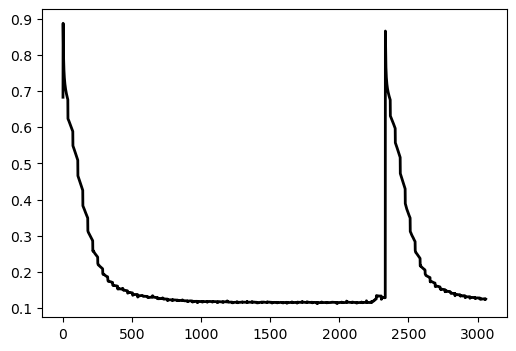

In [19]:

itea=np.arange(0,len(batch_loss_callback.train_batch_losses),1)
loss=batch_loss_callback.train_batch_losses
val_loss=batch_loss_callback.val_batch_losses
loss[0]=0.683
val_loss[0]=0.675

fig = plt.figure(figsize=(6, 4)) 

plt.plot(itea, loss,linewidth=2.0,color='black',label='Loss_train')
plt.plot(itea, val_loss,linewidth=2.0,color='red',label='Loss_test')
plt.legend(loc="best",fontsize=15)

#plt.yscale('log') 
plt.ylim(0,0.8)
plt.ylabel('Probability',fontsize=18)
plt.xlabel('Mapping X (m)',fontsize=18)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tick_params(labelsize=15)
plt.grid()
plt.subplots_adjust(top=0.95,bottom=0.18,left=0.18,right=0.95)
plt.savefig('loss.png',dpi=(300.0))
#plt.savefig('plot/'+name+'.png',dpi=300)

In [76]:
model.save_weights('UNet_model/FTEM.ckpt')
model.save('UNet_model/FTEM.h5')



In [22]:
prediction = model.predict(data_traing_input_tf)

250/250 [==============================] - 100s 401ms/step


In [23]:
np.save('prediction.npy', prediction)

In [26]:
prediction.shape,data_traing_label_tf.shape

((8000, 24, 32, 2), (8000, 24, 32, 2))

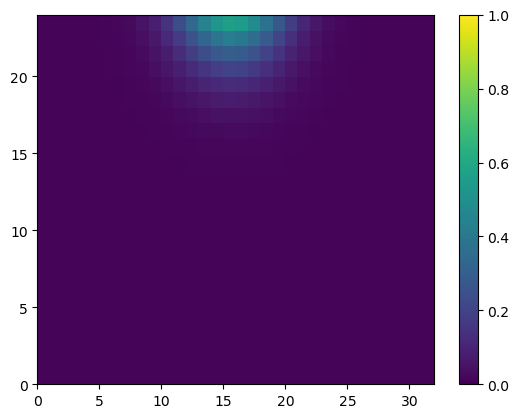

In [52]:
plt.pcolor(data_traing_label_tf[-203,:,:,1])
plt.clim(0,1)
plt.colorbar()

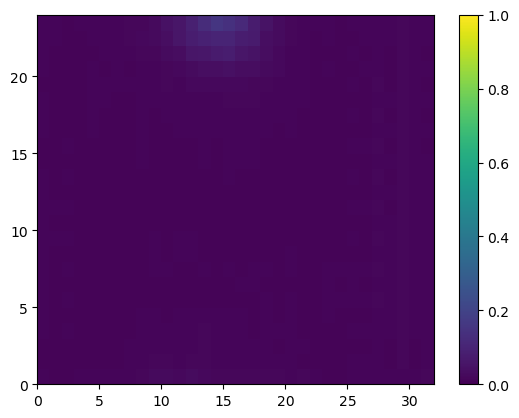

In [53]:
plt.pcolor(prediction[-203,:,:,1])
plt.clim(0,1)
plt.colorbar()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('UNet_model/training_batch.log')
plt.plot(df['epoch'], df['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()